## KNN Model

In [4]:
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class KNNModel:
    def __init__(self):
        self.best_knn = None
        self.grid_search = None

        
    def fit(self, X_train, y_train, param_grid):
        knn = KNeighborsClassifier()
        self.grid_search = GridSearchCV(knn, param_grid, cv=5)
        self.grid_search.fit(X_train, y_train)
        self.best_knn = self.grid_search.best_estimator_
        
        k_values = None
        k_parameter_pattern = re.compile(r'n[_]?neighbors|k[_]?values', re.IGNORECASE)
        for key, value in param_grid.items():
            if isinstance(value, list) and k_parameter_pattern.search(key):
                k_values = value
                break
        
        if k_values is None:
            raise ValueError("K-values not found in param_grid")
        
        # compute the accuracy score for each hyperparameter combination
        cv_results = self.grid_search.cv_results_
        test_scores_mean = cv_results['mean_test_score']
        test_scores_stds = cv_results['std_test_score']
        for mean, std, params in zip(test_scores_mean, test_scores_stds, cv_results['params']):
            print(f"Accuracy: {mean:.3f} (±{std*2:.3f}) for {params}")

        # Display average accuracy for each hyperparameter combination
        results_df = pd.DataFrame(cv_results)
        results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
        param_cols = ['param_' + key for key in param_grid.keys()]
        mean_test_score_col = 'mean_test_score'
        print(results_df_sorted[param_cols + [mean_test_score_col]])

        # print the best hyperparameters
        best_params = self.grid_search.best_params_
        print("Best Hyperparameters:", best_params)

        plt.figure(figsize=(10, 8))
        plt.plot(k_values, 1 - test_scores_mean, label='Training Error')
        plt.xlabel('k')
        plt.ylabel('Error Rate')
        plt.title('Error Rates for k-nearest neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

        min_cv_k = np.argmin(1-test_scores_mean)
        print(f"The number of nearest neighbors (k) associated with the smallest training error is {k_values[min_cv_k]}")
          # Print training accuracy
        train_accuracy = self.best_knn.score(X_train, y_train)
        print(f"Training Accuracy: {train_accuracy}")

        
    def evaluate(self, X_test, y_test):
        if self.best_knn is None:
            raise ValueError("Fit the model before evaluating")
        
        test_accuracy = self.best_knn.score(X_test, y_test)
        print(f"Test Accuracy: {test_accuracy}")
        
        knn_predictions = self.best_knn.predict(X_test)
        
        print("KNN Classification Report:")
        print(classification_report(y_test, knn_predictions))
        
        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, knn_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('KNN Confusion Matrix')
        plt.show()

        #probability estimates for positive class
        y_probs = self.best_knn.predict_proba(X_test)
        # Compute ROC curve and ROC area for each class
        n_classes = len(self.best_knn.classes_)
        plt.figure(figsize=(8, 8))
        if n_classes > 2:
            for i in range(n_classes):
                fpr, tpr, thresholds = roc_curve(y_test == i, y_probs[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {i} vs the rest) (AUC = {roc_auc:.2f})')
        else:
            fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def kfold_cv(self, X_train, y_train, X_test, y_test, k_values):
        training_errors = []
        cv_errors_list = []
        avg_cv_errors = []
        test_errors = []

        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)

            training_error = 1 - knn.score(X_train, y_train)
            cv_errors = cross_val_score(knn, X_train, y_train, cv=10)
            avg_cv_error = 1 - np.mean(cv_errors)
            test_error = 1 - knn.score(X_test, y_test)

            training_errors.append(training_error)
            test_errors.append(test_error)
            avg_cv_errors.append(avg_cv_error)
            cv_errors_list.append(cv_errors)

        plt.figure(figsize=(10, 8))
        plt.plot(k_values, training_errors, label='Training Error')
        plt.plot(k_values, test_errors, label='Test Error')
        plt.plot(k_values, avg_cv_errors, label='CV Error')
        #plt.errorbar(k_values, avg_cv_errors, yerr=np.std(avg_cv_errors), label='CV Error', c='green', marker='o', capsize=5)
        #plt.errorbar(k_values, avg_cv_errors, yerr=[np.std(errors) for errors in cv_errors_list], label='CV Error', c='green', marker='o', capsize=5)
        
        plt.xlabel('k')
        plt.ylabel('Error Rate')
        plt.title('Error Rates for k-nearest neighbors')
        plt.legend()
        plt.grid(True)
        plt.show()

        min_cv_k = np.argmin(avg_cv_errors)
        min_test_k = np.argmin(test_errors)
        print(f"The number of nearest neighbors (k) with the smallest cross-validation error is {k_values[min_cv_k]} and an error of {avg_cv_errors[min_cv_k]}")
        print(f"The number of nearest neighbors (k) with the smallest test error is {k_values[min_test_k]} and an error of {test_errors[min_test_k]}")
        
    def bootstrap(self, X_train, y_train, n_bootstrap, k_folds=5):
        
        bootstrap_accuracy_list = []
        for b in range(n_bootstrap):
            resampled_X_train, resampled_y_train = resample(X_train, y_train, replace=True, random_state=b)
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=b)

            fold_accuracy_list = []
            for train_index, val_index in kf.split(resampled_X_train):
                X_train_fold, X_val_fold = resampled_X_train[train_index], resampled_X_train[val_index]
                y_train_fold, y_val_fold = resampled_y_train[train_index], resampled_y_train[val_index]

                self.best_knn.fit(X_train_fold, y_train_fold)
                fold_accuracy = self.best_knn.score(X_val_fold, y_val_fold)
                fold_accuracy_list.append(fold_accuracy)

            bootstrap_accuracy = np.mean(fold_accuracy_list)
            bootstrap_accuracy_list.append(bootstrap_accuracy)

        # Calculate the 5th and 95th percentiles
        mean_acc = np.mean(bootstrap_accuracy_list)
        percentile_5 = np.percentile(bootstrap_accuracy_list, 5)
        percentile_95 = np.percentile(bootstrap_accuracy_list, 95)
        print("Mean accuracy: ", mean_acc)
        print(f"5th percentile of accuracy: {percentile_5}")
        print(f"95th percentile of accuracy: {percentile_95}")


## Data pre-processing

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

#%% load UCI Adult dataset from downloaded zip folder
labels = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
          'marital-status', 'occupation', 'relationship', 'race', 'sex', 
          'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
          'income']

train_df = pd.read_csv('input/uci-adult/adult.data', na_values='?', header=None, names=labels, skipinitialspace=True)
test_df = pd.read_csv('input/uci-adult/adult.test', na_values='?', header=None, names=labels, skipinitialspace=True)
train_df.dropna(axis=0, how='any', inplace=True)
test_df.dropna(axis=0, how='any', inplace=True)

# keep a copy to compare with processed data
data = pd.concat([train_df, test_df], axis=0)

In [5]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,33,Private,245211.0,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K.
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


In [6]:
#%% analyse features
target = train_df.values[:,14] # change column index 0-14
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=<=50K, Count=22654, Percentage=75.108%
Class=>50K, Count=7508, Percentage=24.892%


In [7]:
#%% drop redundant column
train_df.drop(labels=['education'], axis=1, inplace=True)
test_df.drop(labels=['education'], axis=1, inplace=True)

In [8]:
#%% convert 'income' to integer
salary_map={'<=50K':0,'>50K':1}
salary_map2={'<=50K.':0,'>50K.':1}

train_df['income']=train_df['income'].map(salary_map).astype(int)
test_df['income']=test_df['income'].map(salary_map2).astype(int)

In [9]:
#%% process 'capital-gain' and 'capital-loss'
train_df.loc[(train_df['capital-gain'] > 0),'capital-gain'] = 1    #capital loss and gain has a lot of zero values 
train_df.loc[(train_df['capital-gain'] == 0 ,'capital-gain')]= 0

test_df.loc[(test_df['capital-gain'] > 0),'capital-gain'] = 1    #capital loss and gain has a lot of zero values 
test_df.loc[(test_df['capital-gain'] == 0 ,'capital-gain')]= 0

train_df.loc[(train_df['capital-loss'] > 0),'capital-loss'] = 1
train_df.loc[(train_df['capital-loss'] == 0 ,'capital-loss')]= 0

test_df.loc[(test_df['capital-loss'] > 0),'capital-loss'] = 1
test_df.loc[(test_df['capital-loss'] == 0 ,'capital-loss')]= 0

#%% convert object type data to integers
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        encoder = LabelEncoder()
        encoder.fit(train_df[col])
        train_df[col] = encoder.transform(train_df[col])
        encoder.fit(test_df[col])
        test_df[col] = encoder.transform(test_df[col])

In [10]:
#%% separate X and y
X_train = train_df.drop(['income'], axis=1).to_numpy()
y_train = train_df['income'].to_numpy()
X_test = test_df.drop(['income'], axis=1).to_numpy()
y_test = test_df['income'].to_numpy()

print(X_train.shape)
print(y_train.shape)

(30162, 13)
(30162,)


## PCA

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Get the number of components that explain 95% of variance
original_components = X_train_scaled.shape[1]
p_components = pca.n_components_
print(f"Total Number of components: {original_components}")
print(f"Number of components explaining 95% variance: {p_components}")



Total Number of components: 13
Number of components explaining 95% variance: 12


## Base KNN with scaled data

Accuracy: 0.784 (±0.007) for {'n_neighbors': 1}
Accuracy: 0.803 (±0.008) for {'n_neighbors': 2}
Accuracy: 0.809 (±0.014) for {'n_neighbors': 3}
Accuracy: 0.817 (±0.010) for {'n_neighbors': 4}
Accuracy: 0.819 (±0.010) for {'n_neighbors': 5}
Accuracy: 0.822 (±0.014) for {'n_neighbors': 6}
Accuracy: 0.822 (±0.006) for {'n_neighbors': 7}
Accuracy: 0.824 (±0.009) for {'n_neighbors': 8}
Accuracy: 0.825 (±0.009) for {'n_neighbors': 9}
Accuracy: 0.826 (±0.009) for {'n_neighbors': 10}
Accuracy: 0.827 (±0.008) for {'n_neighbors': 11}
Accuracy: 0.827 (±0.006) for {'n_neighbors': 12}
Accuracy: 0.827 (±0.006) for {'n_neighbors': 13}
Accuracy: 0.828 (±0.007) for {'n_neighbors': 14}
Accuracy: 0.828 (±0.006) for {'n_neighbors': 15}
Accuracy: 0.828 (±0.006) for {'n_neighbors': 16}
Accuracy: 0.827 (±0.008) for {'n_neighbors': 17}
Accuracy: 0.829 (±0.005) for {'n_neighbors': 18}
Accuracy: 0.827 (±0.007) for {'n_neighbors': 19}
Accuracy: 0.828 (±0.007) for {'n_neighbors': 20}
Accuracy: 0.827 (±0.006) for 

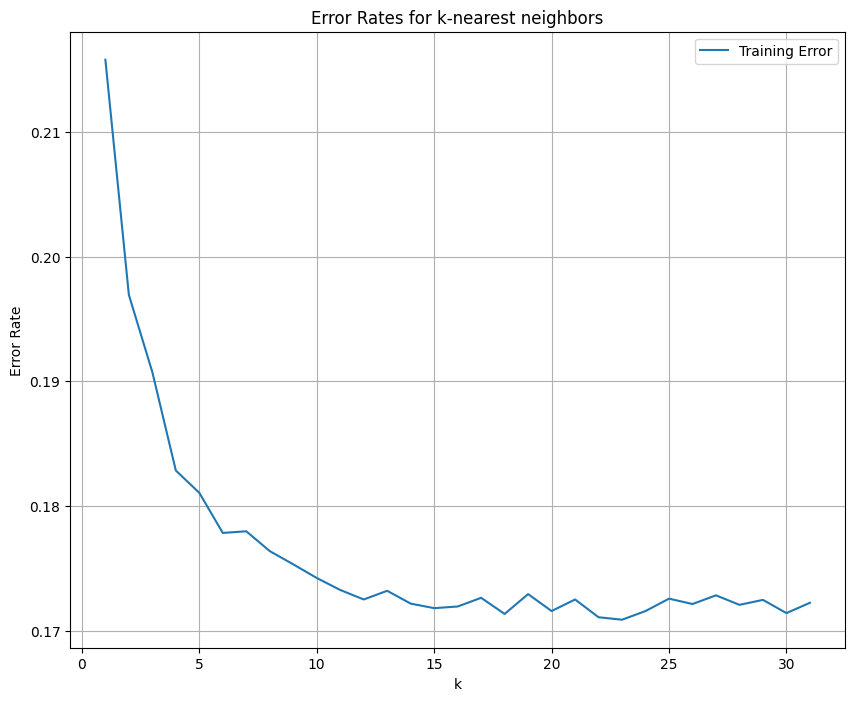

The number of nearest neighbors (k) associated with the smallest training error is 23
Training Accuracy: 0.844572641071547


In [12]:
#Base KNN model
knn_model = KNNModel()
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_model.fit(X_train_scaled, y_train, param_grid)

Test Accuracy: 0.8307436918990704
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11360
           1       0.67      0.61      0.64      3700

    accuracy                           0.83     15060
   macro avg       0.77      0.75      0.76     15060
weighted avg       0.83      0.83      0.83     15060



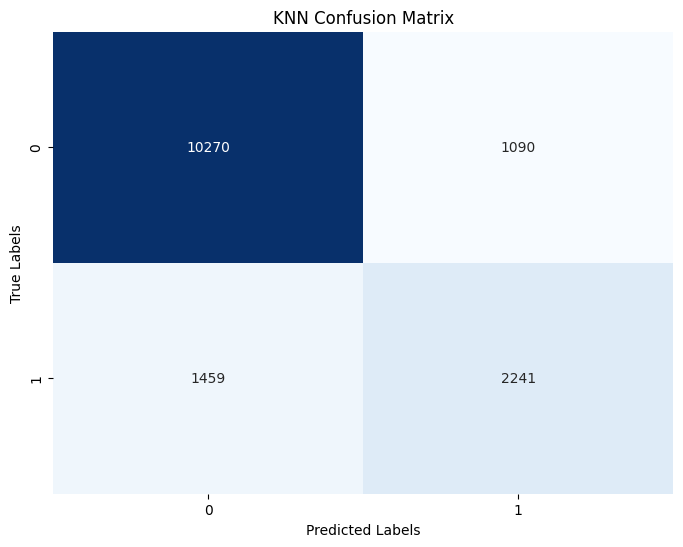

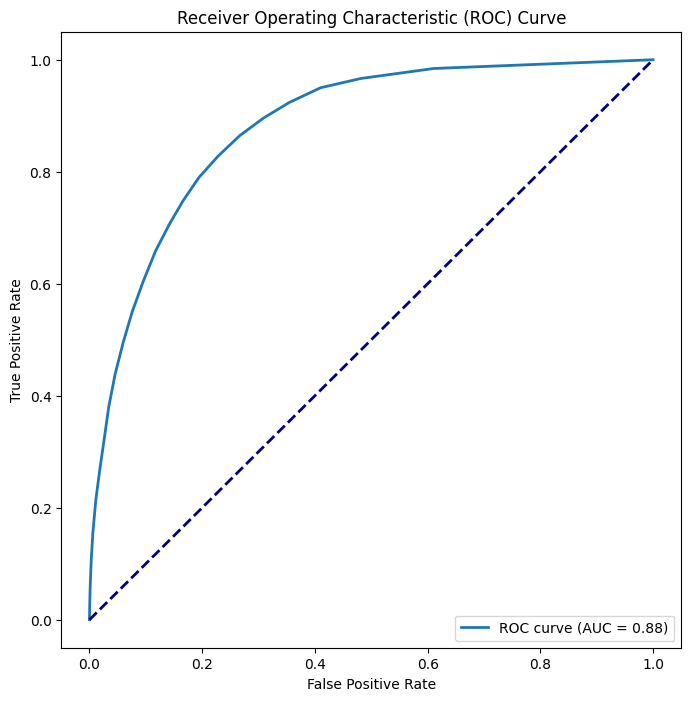

In [13]:
knn_model.evaluate(X_test_scaled, y_test)

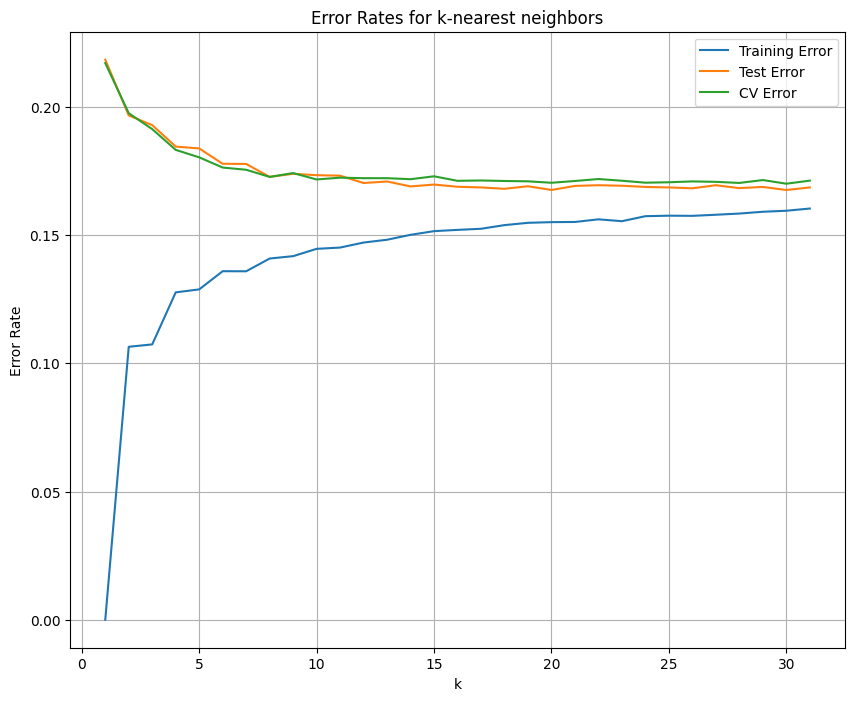

The number of nearest neighbors (k) with the smallest cross-validation error is 30 and an error of 0.1700483181511665
The number of nearest neighbors (k) with the smallest test error is 20 and an error of 0.16759628154050465


In [14]:
#KFold cross validation KNN
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_model.kfold_cv(X_train_scaled, y_train, X_test_scaled, y_test, param_grid['n_neighbors'])

## Bootstrap resampling with base KNN

In [36]:
n_bootstrap = 300
knn_model.bootstrap(X_train_scaled, y_train, n_bootstrap)





Mean accuracy:  0.8377262946148087
5th percentile of accuracy: 0.8354368991105946
95th percentile of accuracy: 0.8411891619743049


## KNN + PCA

Accuracy: 0.784 (±0.007) for {'n_neighbors': 1}
Accuracy: 0.803 (±0.009) for {'n_neighbors': 2}
Accuracy: 0.809 (±0.014) for {'n_neighbors': 3}
Accuracy: 0.817 (±0.011) for {'n_neighbors': 4}
Accuracy: 0.818 (±0.011) for {'n_neighbors': 5}
Accuracy: 0.822 (±0.014) for {'n_neighbors': 6}
Accuracy: 0.822 (±0.008) for {'n_neighbors': 7}
Accuracy: 0.824 (±0.009) for {'n_neighbors': 8}
Accuracy: 0.824 (±0.008) for {'n_neighbors': 9}
Accuracy: 0.825 (±0.010) for {'n_neighbors': 10}
Accuracy: 0.827 (±0.007) for {'n_neighbors': 11}
Accuracy: 0.827 (±0.006) for {'n_neighbors': 12}
Accuracy: 0.828 (±0.005) for {'n_neighbors': 13}
Accuracy: 0.828 (±0.007) for {'n_neighbors': 14}
Accuracy: 0.828 (±0.007) for {'n_neighbors': 15}
Accuracy: 0.828 (±0.006) for {'n_neighbors': 16}
Accuracy: 0.827 (±0.007) for {'n_neighbors': 17}
Accuracy: 0.827 (±0.005) for {'n_neighbors': 18}
Accuracy: 0.827 (±0.007) for {'n_neighbors': 19}
Accuracy: 0.828 (±0.006) for {'n_neighbors': 20}
Accuracy: 0.827 (±0.006) for 

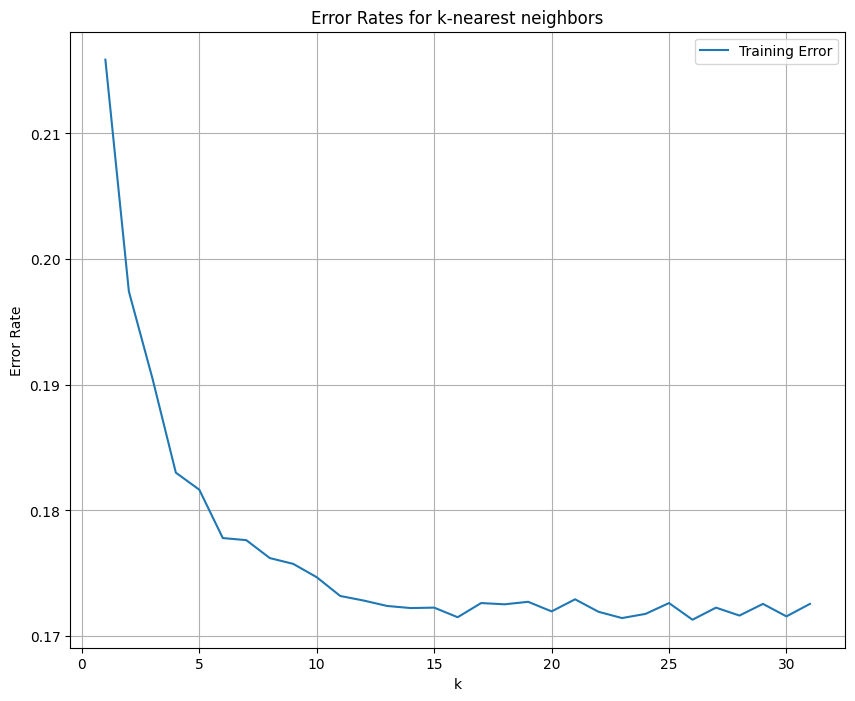

The number of nearest neighbors (k) associated with the smallest training error is 26
Training Accuracy: 0.8417545255619654


In [15]:
#Base KNN model
knn_pca_model = KNNModel()
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_pca_model.fit(X_train_pca, y_train, param_grid)

Test Accuracy: 0.8310756972111554
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     11360
           1       0.68      0.58      0.63      3700

    accuracy                           0.83     15060
   macro avg       0.78      0.75      0.76     15060
weighted avg       0.82      0.83      0.83     15060



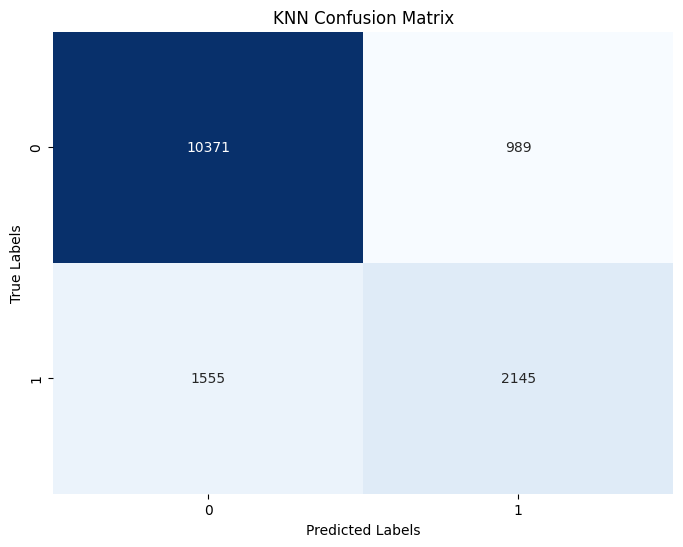

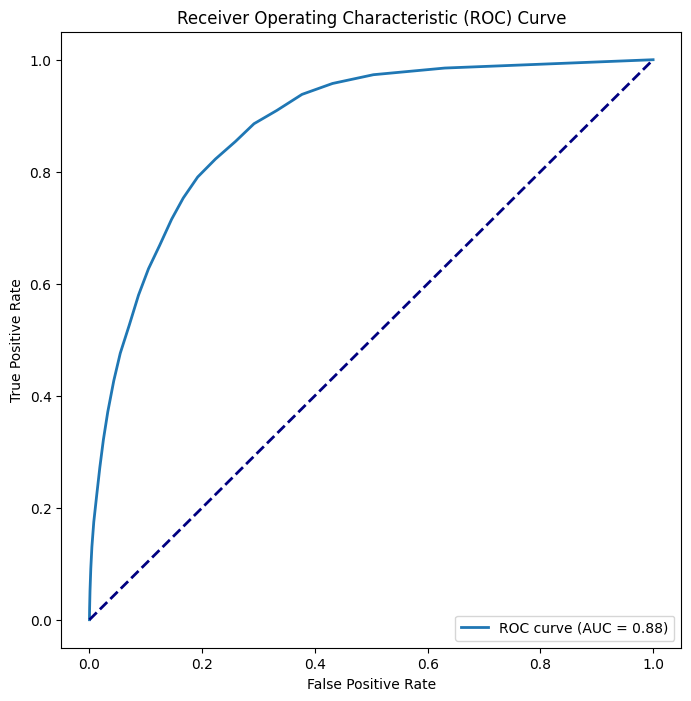

In [16]:
knn_pca_model.evaluate(X_test_pca, y_test)

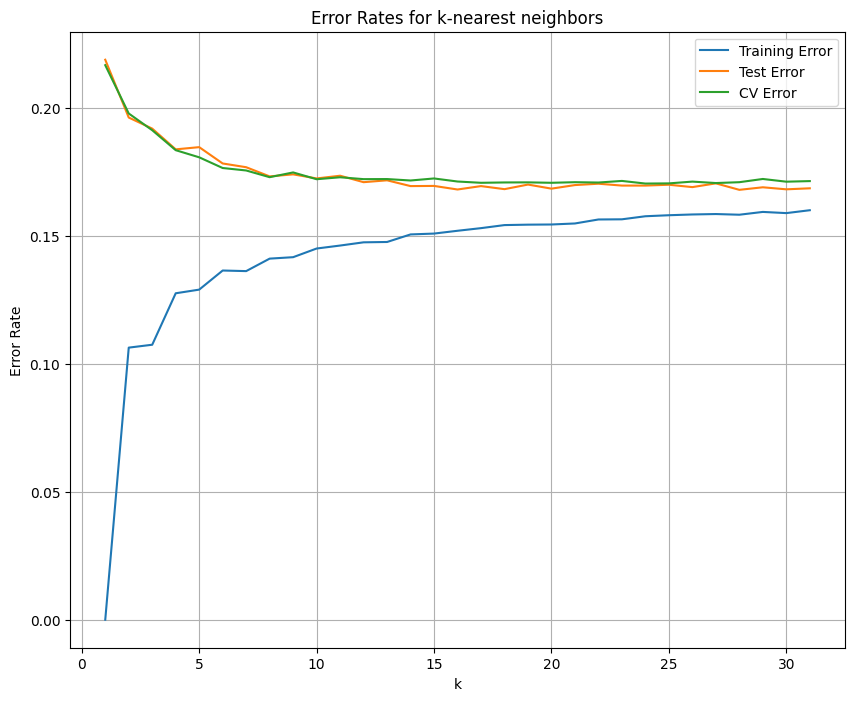

The number of nearest neighbors (k) with the smallest cross-validation error is 24 and an error of 0.17031340529220373
The number of nearest neighbors (k) with the smallest test error is 28 and an error of 0.1678618857901727


In [17]:
#KFold cross validation KNN
param_grid = {'n_neighbors': list(range(1, 32))}
#param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_pca_model.kfold_cv(X_train_pca, y_train, X_test_pca, y_test, param_grid['n_neighbors'])

In [19]:
from sklearn.utils import resample
n_bootstrap = 300
knn_pca_model.bootstrap(X_train_scaled, y_train, n_bootstrap)

Mean accuracy:  0.8336081780460929
5th percentile of accuracy: 0.83014723397969
95th percentile of accuracy: 0.8373202451173717
